# Clockwork Axion

In [1]:
%run observables.py
%run clockwork_axion.py
%run plot_tools.py
%run util.py
%run analysis_tools.py
import tqdm.notebook
plt.rcParams["font.size"] = 12

## $m_\phi$ vs $mR$ parameterspace from Paper

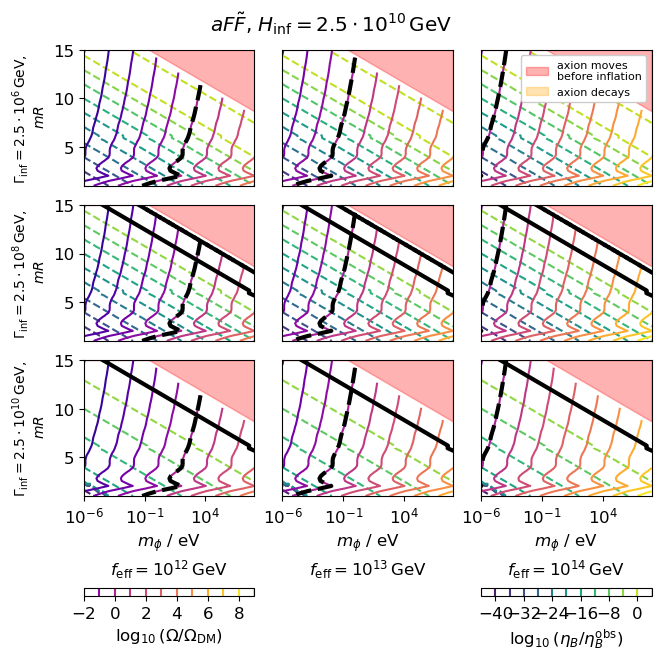

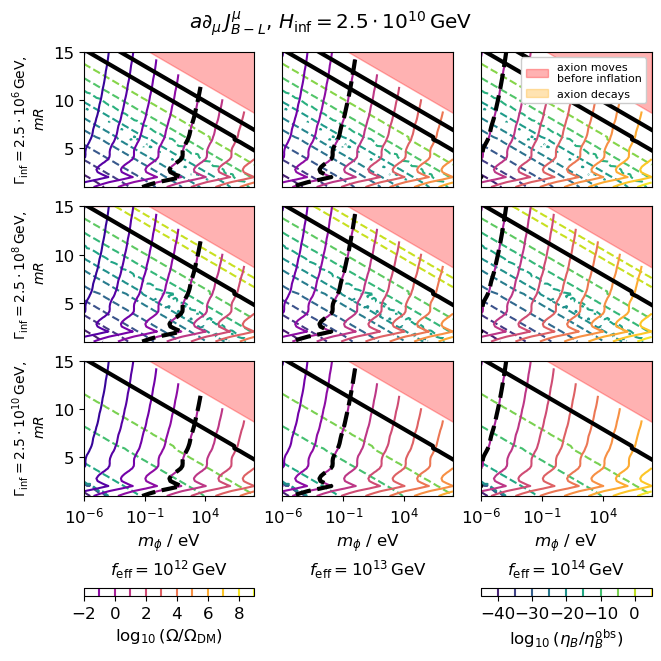

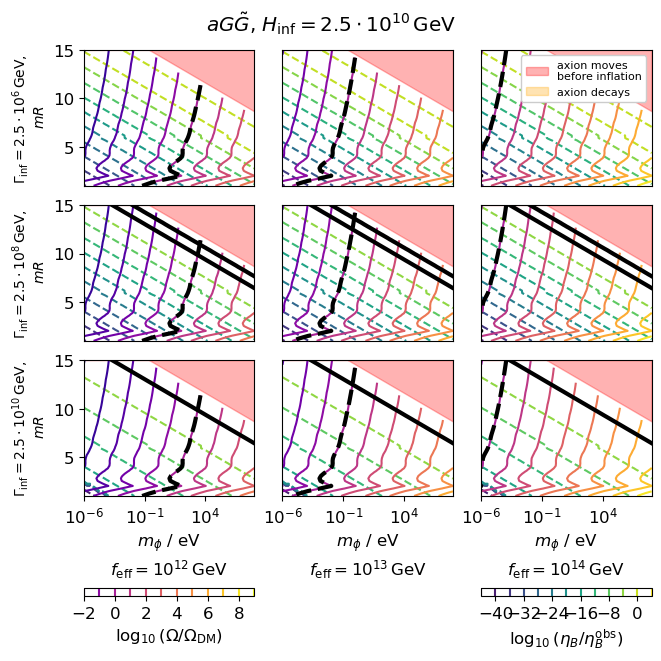

In [2]:
for v in range(1, 3 + 1):
    data = load_data("clockwork_mR_vs_mphi", v)
    m_phi = data["m_phi"]
    mR = data["mR"]
    H_inf = data["H_inf"][0]
    f_effs = [1e12, 1e13, 1e14]
    Gamma_infs = data["Gamma_inf"]
    max_mR = np.array([compute_max_mR(x, H_inf, 3*np.pi/4) for x in m_phi])

    fig, axs = plt.subplots(len(Gamma_infs), len(f_effs), figsize=(6.5, 6.5), constrained_layout=True)
    #fig.subplots_adjust(wspace=0, hspace=0)

    def recompute_relic_density(old_Omega_h_sq, new_f_eff):
        eps = calc_eps(mR)
        old_f = calc_f(default_f_eff, eps)
        new_f = calc_f(new_f_eff, eps)
        new_Omega_h_sq = old_Omega_h_sq / old_f[:, None]**2 * new_f[:, None]**2
        return new_Omega_h_sq

    Bs = [[np.log10(recompute_relic_density(data["Omega_h_sq"][0, Gamma_inf_index, ..., 0], f_eff) / Omega_DM_h_sq) 
        for f_eff in f_effs] for Gamma_inf_index in range(len(Gamma_infs))]
    vmin_B = min(np.nanmin(B) for row in Bs for B in row)
    vmax_B = max(np.nanmax(B) for row in Bs for B in row)

    for i, Gamma_inf in enumerate(Gamma_infs):
        A = np.log10(np.abs(data["eta"][0, i, ..., 0]) / eta_B_observed)

        for j, f_eff in enumerate(f_effs):
            min_mR = np.array([compute_min_mR(x, f_eff, transport_equation.source_vectors[v - 1]) for x in m_phi])
            Omega_level = list(find_level(np.log10(m_phi * 1e9), mR, Bs[i][j]))
            eta_level = list(find_level(np.log10(m_phi * 1e9), mR, A))

            axs[i, j].set_xscale("log")

            contour1 = axs[i, j].contour(m_phi * 1e9, mR, A, levels=10, cmap="viridis", linestyles="--")
            contour2 = axs[i, j].contour(m_phi * 1e9, mR, Bs[i][j], levels=10, cmap="plasma", linestyles="-", vmin=vmin_B, vmax=vmax_B)

            for xs, ys in eta_level:
                axs[i, j].plot(10**xs, ys, "k", lw=3)
            for xs, ys in Omega_level:
                axs[i, j].plot(10**xs, ys, "--k", lw=3)

            #if len(eta_level) > 0 and len(Omega_level) > 0:
            #    x, y = find_curve_intersection(*eta_level[0], *Omega_level[0])
            #    axs[i, j].plot([10**x], [y], "ro")

            axs[i, j].fill_between(m_phi * 1e9, max_mR, mR[-1], alpha=0.3, color="red", label="axion moves\nbefore inflation")
            axs[i, j].fill_between(m_phi * 1e9, min_mR, mR[0] , alpha=0.3, color="orange", label="axion decays")
            if (i, j) == (0, 2):
                axs[i, j].legend(framealpha=1, fontsize=8, loc="upper right")
            axs[i, j].set_ylim(mR[0], mR[-1])

            if j != 0:
                axs[i, j].set_yticks([], [])
            else:
                axs[i, j].set_ylabel(r"$\Gamma_\mathrm{inf} = " + latex_exponential_notation(Gamma_inf, 1) + r"\, \mathrm{GeV}$" + ",\n $mR$", fontsize=10)                   
            if i != len(Gamma_infs) - 1:
                axs[i, j].set_xticks([], [])
            else:
                axs[i, j].set_xlabel("$m_\phi$ / eV" + "\n" + r"$f_\mathrm{eff} = " + latex_exponential_notation(f_eff, 2) + r"\, \mathrm{GeV}$")

    fig.suptitle(f"{transport_equation.source_vector_names[v - 1]}, $H_\\mathrm{{inf}} = {latex_exponential_notation(H_inf, 1)} \\, \\mathrm{{GeV}}$")
    cbar2 = fig.colorbar(contour2, ax=axs[-1, 0], label=r"$\log_{10}(\Omega / \Omega_\mathrm{DM})$", shrink=1, location="bottom")
    cbar1 = fig.colorbar(contour1, ax=axs[-1, -1], label=r"$\log_{10}(\eta_B / \eta^\mathrm{obs}_B)$", shrink=1, location="bottom") 

    fig.savefig(os.path.join(plotpath, f"cw_m_phi_vs_mR_{v}.pdf"))

## $m_\phi$ vs $\Gamma_\mathrm{inf}$ parameterspace

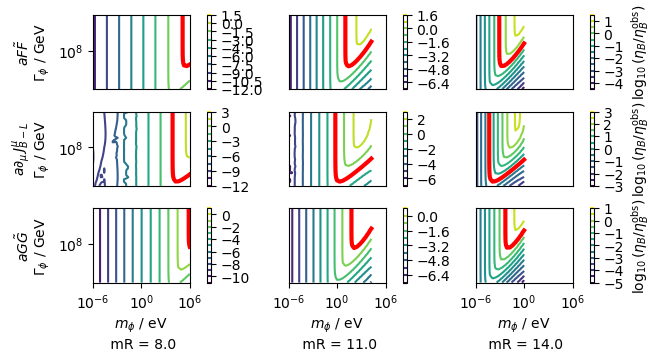

In [3]:
plt.rcParams["font.size"] = 10
data = load_data("clockwork_Gammainf_vs_mphi", 1)
m_phi = data["m_phi"]
mRs = data["mR"]
H_inf = data["H_inf"][0]
Gamma_infs = data["Gamma_inf"]
fig, axs = plt.subplots(3, len(mRs), figsize=(6.5, 3.5), constrained_layout=True)

for v in range(1, 3 + 1):
    As = [np.log10(np.abs(data["eta"][0, :, i, :, v - 1]) / eta_B_observed) for i in range(len(mRs))]
    minval = min(np.nanmin(A) for A in As)
    maxval = max(np.nanmax(A) for A in As)

    for i, mR in enumerate(mRs):
        contour1 = axs[v - 1, i].contour(m_phi * 1e9, Gamma_infs, As[i], # vmin=minval, vmax=maxval,
                               levels=10, cmap="viridis", linestyles="-")

        try:
            for xs, ys in find_level(np.log10(m_phi * 1e9), np.log10(Gamma_infs), As[i]):
                axs[v - 1, i].plot(10**xs, 10**ys, "r", lw=3)
        except Exception as e:
            print(e)

        axs[v - 1, i].set_xscale("log")
        axs[v - 1, i].set_yscale("log")
        if i == 0:
            axs[v - 1, i].set_ylabel(transport_equation.source_vector_names[v - 1] + "\n" + "$\Gamma_\phi$ / GeV")
        else:
            axs[v - 1, i].set_yticks([], [])
        if v == 3:
            axs[v - 1, i].set_xlabel(f"$m_\\phi$ / eV" + f"\n mR = {mR}")
        else:
            axs[v - 1, i].set_xticks([], [])

        fig.colorbar(contour1, ax=axs[v - 1, i], label=r"$\log_{10}(\eta_B / \eta^\mathrm{obs}_B)$" if i == 2 else None)
    #plt.title(f"$H_\\mathrm{{inf}} = {latex_exponential_notation(H_inf, 2)} \\, \\mathrm{{GeV}}, \\, mR = {mR}$")
fig.savefig(os.path.join(plotpath, "cw_m_phi_vs_Gamma_inf.pdf"))

## Plot of the effective Potential

/tmp/ipykernel_237086/3085815466.py:24: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mappable=mappable, label="mR")


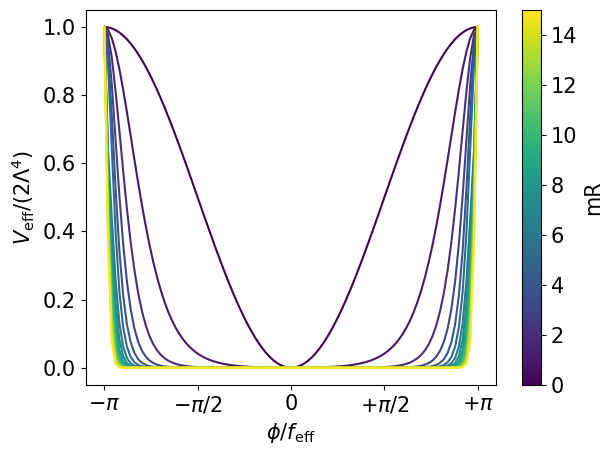

In [4]:
mRs = np.arange(0, 15 + 1, 1) 
cmap = plt.cm.get_cmap("viridis")
norm = mpl.colors.Normalize(vmin=np.min(mRs), vmax=np.max(mRs))
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
plt.rcParams["font.size"] = 15

plt.figure()
for mR in mRs:
    eps = calc_eps(mR)
    alpha_range = np.linspace(-np.pi, np.pi, 100)
    f = 1 # dummy values
    m_phi = 1 # [GeV] # dummy value
    M = m_phi / eps 
    phi_over_f_range = calc_f_eff(f, eps) * alpha_range / f # not a linear map
    Lambda = np.sqrt(M * f)
    y = calc_V_eff_over_f_sq(phi_over_f_range, eps, M) * f**2 / (2*Lambda**4)
    y[0] = 1; y[-1] = 1 # okay this is bad
    c = mappable.to_rgba(mR)
    plt.plot(alpha_range, y, color=c)
    
plt.xlabel(r"$\phi / f_\mathrm{eff}$")
plt.ylabel(r"$V_\mathrm{eff} / (2 \Lambda^4)$")
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r"$-\pi$", r"$-\pi/2$", "0", r"$+\pi/2$", r"$+\pi$",])
plt.colorbar(mappable=mappable, label="mR")
plt.tight_layout()
plt.savefig(os.path.join(plotpath, "cw_potential.pdf"))

## Plot of Field Evolution

In [5]:
H_inf = 2e12
Gamma_inf = 1e8
mR = 6
m_phi = 100 * 1e-9 # [GeV]

eps = calc_eps(mR)
M = m_phi / eps 
phi0_over_f = theta_to_phi_over_f(1.0, eps)
tmax_ax = 1 / (eps / 3) * 1e2
tmax_inf = tmax_ax / M * Gamma_inf
_, T_and_H_fn, _ = decay_process.solve(tmax_inf, 0.0, 3*H_inf**2*decay_process.M_pl**2, M, Gamma_inf)
sol = clockwork_axion_field.solve((phi0_over_f, 0.0), (eps, M), tmax_ax, T_and_H_fn, Gamma_inf)
i = np.where(sol.y[0] < 0)[0][0]

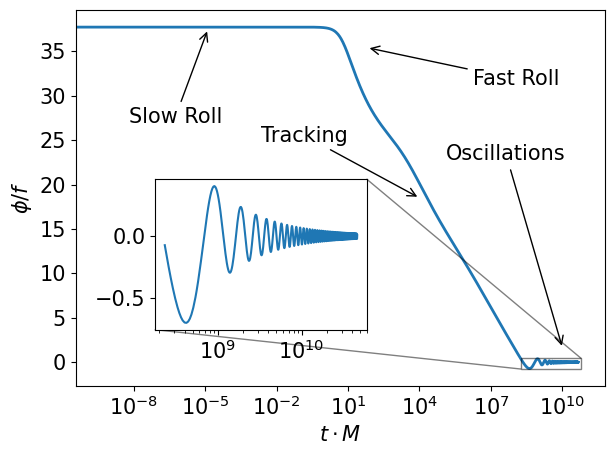

In [6]:
plt.figure()
plt.semilogx(sol.t, sol.y[0, :], lw=2)
plt.xlabel(r"$t \cdot M$")
plt.ylabel(r"$\phi / f$ ")

def annotate(text, arrowxy, textxy):
    plt.annotate(text, xy=arrowxy, xytext=textxy, 
        arrowprops=dict(arrowstyle="->"), xycoords="axes fraction", textcoords="axes fraction")
    
annotate("Slow Roll", (0.25, 1 - 0.05), (0.1, 0.7))
annotate("Fast Roll", (0.55, 1 - 0.1), (0.75, 1 - 0.2))
annotate("Tracking", (0.65, 0.5), (0.35, 0.65))
annotate("Oscillations", (1 - 0.08, 0.1), (0.7, 0.6))

ax = plt.gca()
inset_ax = ax.inset_axes([0.15, 0.15, 0.4, 0.4])
inset_ax.semilogx(sol.t[i:], sol.y[0, i:])
ax.indicate_inset_zoom(inset_ax, edgecolor="black")

plt.tight_layout()
plt.savefig(os.path.join(plotpath, "cw_field_evolution.pdf"))

## Plot of Parts of the Potential

/home/anna-jana/Documents/masters-project/transport_eq_in_time/clockwork_axion.py:52: RuntimeWarning: divide by zero encountered in divide
  return M**2 * 2 / (1 + 1 / calc_u(phi_over_f, eps)**2)


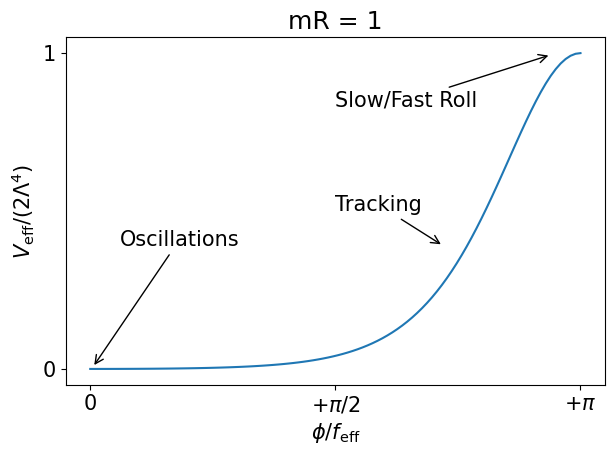

In [7]:
plt.rcParams["font.size"] = 15

plt.figure()
mR = 1
eps = calc_eps(mR)
alpha_range = np.linspace(0, np.pi, 100)
f = 1 # dummy values
m_phi = 1 # [GeV] # dummy value
M = m_phi / eps 
phi_over_f_range = calc_f_eff(f, eps) * alpha_range / f # not a linear map
Lambda = np.sqrt(M * f)
y = calc_V_eff_over_f_sq(phi_over_f_range, eps, M) * f**2 / (2*Lambda**4)
plt.plot(alpha_range, y)

annotate("Slow/Fast Roll", (0.9, 0.95,), (0.5, 0.8))
annotate("Tracking", (3/4 - 0.05, 0.4), (0.5, 0.5))
annotate("Oscillations", (0.05, 0.05), (0.1, 0.4))

plt.xlabel(r"$\phi / f_\mathrm{eff}$")
plt.ylabel(r"$V_\mathrm{eff} / (2 \Lambda^4)$")
plt.xticks([0, np.pi/2, np.pi], ["0", r"$+\pi/2$", r"$+\pi$",])
plt.yticks([0, 1], ["0", "1"])
plt.title(f"{mR = }")
plt.tight_layout()
plt.savefig(os.path.join(plotpath, "cw_potential_parts.pdf"))

## Exploration plots

In [8]:
all_interesting_solutions = load_pkl(example_trajectories_filename)

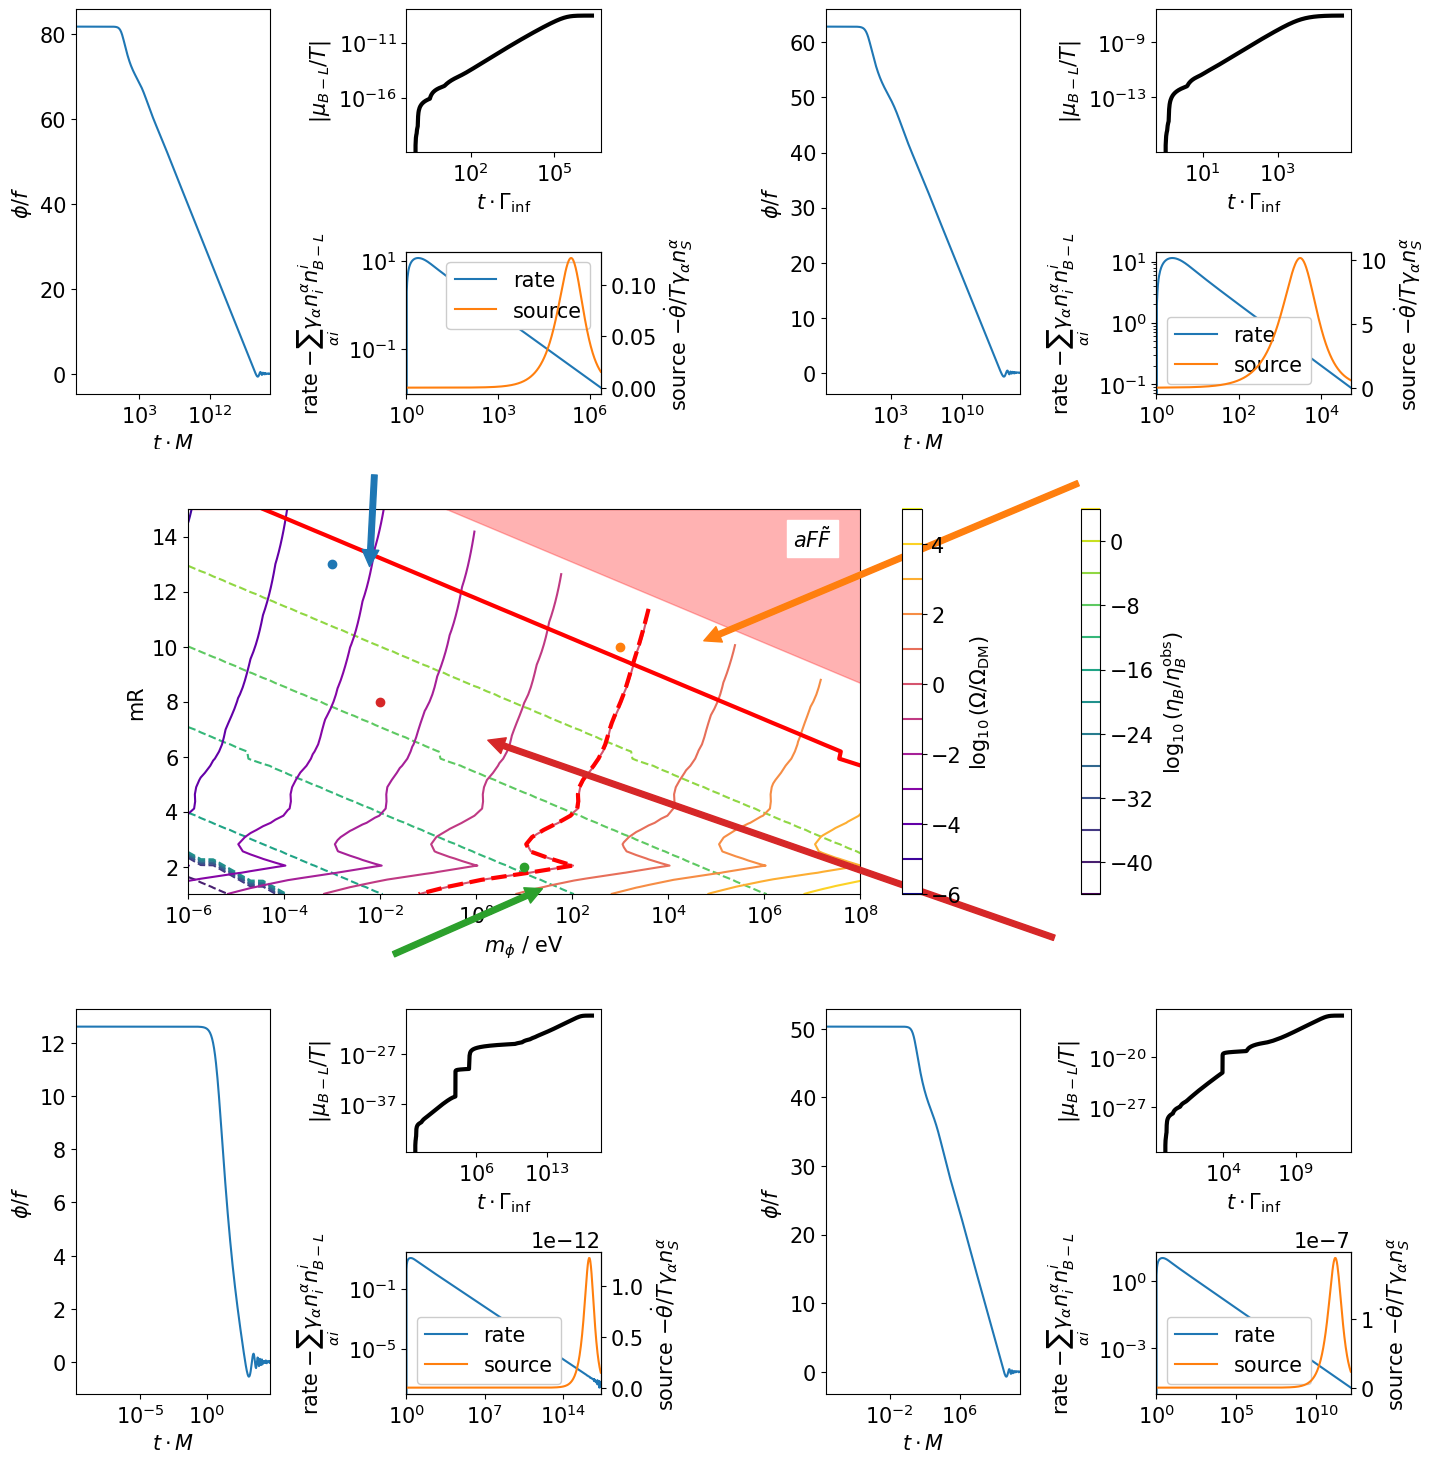

In [9]:
v = 1 # source vector
data = load_data("clockwork_mR_vs_mphi", v)
m_phi, mR = data["m_phi"], data["mR"]
H_inf = data["H_inf"][0]
nsource = int(data["nsource_vector"][0])
source_name = transport_equation.source_vector_names[nsource]
f = 1e12
Gamma_inf_index = 2 # TODO loop
Gamma_inf = data["Gamma_inf"][Gamma_inf_index]
interesting_solutions = all_interesting_solutions[(v, Gamma_inf_index)]
    
A = np.log10(np.abs(data["eta"][0, Gamma_inf_index, :, :, 0]) / eta_B_observed)
B = np.log10(data["Omega_h_sq"][0, Gamma_inf_index, :, :, 0] / Omega_DM_h_sq)

max_mR = np.array([compute_max_mR(x, H_inf, 3*np.pi/4) for x in m_phi])
min_mR = np.array([compute_min_mR(x, default_f_eff, transport_equation.source_vectors[v - 1]) for x in m_phi])

levels_A = list(find_level(np.log10(m_phi * 1e9), mR, A))
levels_B = list(find_level(np.log10(m_phi * 1e9), mR, B))

fig, axs = plt.subplots(3, 2, figsize=(15, 15))
fig_inv_trans = fig.transFigure.inverted()

subfig_fig = []

############################### example evolution plots #################################
for nth_point, (i, j) in enumerate(itertools.product([0, 2], range(2))):  
    gridspec = axs[i, j].get_subplotspec().get_gridspec()
    axs[i, j].remove()
    subfig = fig.add_subfigure(gridspec[i, j])
    subaxs = subfig.subplot_mosaic(
        """
        AB
        AC
        """
    )
    ax1, ax2, ax3 = subaxs["B"], subaxs["A"], subaxs["C"]
    twinax3 = ax3.twinx()
    border = 0.15
    subfig.subplots_adjust(left=border, right=1 - border, hspace=0.7, wspace=0.7)
    # subfig.subplots_adjust(hspace=0, left=border, right=1 - border)
    subfig_fig.append(fig_inv_trans.transform(
        subfig.transSubfigure.transform((0.5, 1 + 0.001) if i == 2 else (0.5, -0.001))))
    
    B_minus_L, source, rate, ts, phi_over_f, relic_ts = interesting_solutions[nth_point]
    
    ax1.loglog(ts, np.abs(B_minus_L), color="k", lw=3)
    ax1.set_ylabel(r"$|\mu_{B - L} / T|$")
    ax1.set_xlabel(r"$t \cdot \Gamma_\mathrm{inf}$")
    
    l1, = ax3.loglog(ts, rate, label="rate", color="tab:blue")
    l2, = twinax3.semilogx(ts, source, label="source", color="tab:orange", zorder=-5)
    ax3.set_xlim(ts[0], ts[-1])
    ax3.set_ylabel(r"rate $- \sum_{\alpha i} \gamma_\alpha n^\alpha_i n_{B - L}^i$")
    twinax3.set_ylabel(r"source $- \dot{\theta} / T \gamma_\alpha n_S^\alpha $")
    ax3.legend([l1, l2], ["rate", "source"], framealpha=1)
    # twinax3.legend(framealpha=1)
    
    ax2.semilogx(relic_ts, phi_over_f)
    ax2.set_xlabel(r"$t \cdot M$")
    ax2.set_xlim(relic_ts[1], relic_ts[-1])
    ax2.set_ylabel(r"$\phi / f$")
        
############################### parameter-space plot ###############################
for j in range(2):
    axs[1, j].remove()
gridspec = axs[1, 0].get_subplotspec().get_gridspec()
subfig = fig.add_subfigure(gridspec[1, :])
ax = subfig.subplots()

ax.set_xscale("log")

ax.set_xlabel(r"$m_\phi$ / eV")
ax.set_ylabel("mR")

ax.annotate(source_name, (0.9, 0.9), xycoords="axes fraction", backgroundcolor="white")

mappable_A = ax.contour(m_phi * 1e9, mR, A, levels=10, cmap="viridis", linestyles="--")
mappable_B = ax.contour(m_phi * 1e9, mR, B, levels=10, cmap="plasma", linestyles="-")

subfig.colorbar(mappable_A, ax=ax, label=r"$\log_{10}(\eta_B / \eta_B^\mathrm{obs})$")
subfig.colorbar(mappable_B, ax=ax, label=r"$\log_{10}(\Omega / \Omega_\mathrm{DM})$")

for xs, ys in levels_A:
    ax.plot(10**xs, ys, "r", lw=3)
for xs, ys in levels_B:
    ax.plot(10**xs, ys, "--r", lw=3)

ax.fill_between(m_phi * 1e9, max_mR, mR[-1], alpha=0.3, color="red", label="axion moves before inflation")
ax.fill_between(m_phi * 1e9, min_mR, mR[0] , alpha=0.3, color="orange", label="axion decays")
ax.set_ylim(mR[0], mR[-1])

###################################### arrows ##################################
interesting_points_marker_colors = []
interesting_points_fig = []
for p in interesting_points:
    l, = ax.plot(*p, "o")
    interesting_points_marker_colors.append(l.get_markerfacecolor())
    interesting_points_fig.append(fig_inv_trans.transform(ax.transData.transform(p)))

for arrow_end, arrow_start, arrow_color in zip(interesting_points_fig, subfig_fig, 
                                               interesting_points_marker_colors):
    ax.annotate("", xy=arrow_end, xytext=arrow_start, xycoords="figure fraction", 
                 textcoords="figure fraction", arrowprops=dict(color=arrow_color, shrink=0.1))
    
fig.savefig(os.path.join(plotpath, "cw_exploration_plot.pdf"))